In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/personal-key-indicators-of-heart-disease/2020/heart_2020_cleaned.csv
/kaggle/input/personal-key-indicators-of-heart-disease/2022/heart_2022_with_nans.csv
/kaggle/input/personal-key-indicators-of-heart-disease/2022/heart_2022_no_nans.csv


In [50]:
# Veri Seti Hakkında:
# Bu veri seti, ABD'deki 400.000'den fazla yetişkinin kalp hastalığı ile ilgili sağlık durumunu
# içeren CDC'nin anket verilerinden oluşmaktadır. Kalp hastalığına yol açan risk faktörlerini
# belirlemek ve tahmin modelleri geliştirmek için kullanılabilir.
# ancak bu data "dengesiz veri" özelliğine sahiptir
# bu yüzden veriyi dengelemek için ya azınlık veriyi artıracağız ya da çoğunluk veriyi silerek dengeleyeceğiz
# elimizdeki veri büyük bir veri olduğu için(400 000) çoğunluk veri türünden azaltma yoluna gidebiliriz
# ve eğitim için kullanacağımız modeli seçerkende dengesiz veriler ile başa çıkabilecek bir model tercih edeceğiz

# veriyi okuyacağız ve birkaç satırı inceleyeceğiz
# ilgili datadaki "heart_2022_with_nans.csv" adlı veriyi kullanacağız.
# bu veri bazı ekisk değerleri barındırıyor bu değerleri işleyeceğiz,

df = pd.read_csv('/kaggle/input/personal-key-indicators-of-heart-disease/2022/heart_2022_with_nans.csv')

print(df.head())

     State     Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0  Alabama  Female     Very good                 0.0               0.0   
1  Alabama  Female     Excellent                 0.0               0.0   
2  Alabama  Female     Very good                 2.0               3.0   
3  Alabama  Female     Excellent                 0.0               0.0   
4  Alabama  Female          Fair                 2.0               0.0   

                                     LastCheckupTime PhysicalActivities  \
0  Within past year (anytime less than 12 months ...                 No   
1                                                NaN                 No   
2  Within past year (anytime less than 12 months ...                Yes   
3  Within past year (anytime less than 12 months ...                Yes   
4  Within past year (anytime less than 12 months ...                Yes   

   SleepHours RemovedTeeth HadHeartAttack  ... HeightInMeters  \
0         8.0          NaN             

In [51]:
# Tüm sütun isimlerini alt alta görüntüle
for column in df.columns:
    print(column)


State
Sex
GeneralHealth
PhysicalHealthDays
MentalHealthDays
LastCheckupTime
PhysicalActivities
SleepHours
RemovedTeeth
HadHeartAttack
HadAngina
HadStroke
HadAsthma
HadSkinCancer
HadCOPD
HadDepressiveDisorder
HadKidneyDisease
HadArthritis
HadDiabetes
DeafOrHardOfHearing
BlindOrVisionDifficulty
DifficultyConcentrating
DifficultyWalking
DifficultyDressingBathing
DifficultyErrands
SmokerStatus
ECigaretteUsage
ChestScan
RaceEthnicityCategory
AgeCategory
HeightInMeters
WeightInKilograms
BMI
AlcoholDrinkers
HIVTesting
FluVaxLast12
PneumoVaxEver
TetanusLast10Tdap
HighRiskLastYear
CovidPos


In [52]:
# Her sütun için benzersiz değerleri görüntüle
for column in df.columns:
    print(f"Sütun: {column}")
    print(df[column].unique())
    print("\n")

Sütun: State
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']


Sütun: Sex
['Female' 'Male']


Sütun: GeneralHealth
['Very good' 'Excellent' 'Fair' 'Poor' 'Good' nan]


Sütun: PhysicalHealthDays
[ 0.  2.  1.  8.  5. 30.  4. 23. 14. nan 15.  3. 10.  7. 25.  6. 21. 20.
 29. 16.  9. 27. 28. 12. 13. 11. 26. 17. 24. 19. 18. 22.]


Sütun: MentalHealthDays
[ 0.  3.  9.  5. 15. 20. 14. 10. 18.  1. nan  2. 30. 

In [53]:
# verideki dengesizliği görelim 

heart_attack_counts = df['HadHeartAttack'].value_counts()
heart_attack_percentages = df['HadHeartAttack'].value_counts(normalize=True) * 100
heart_attack_summary = pd.DataFrame({
    'Count': heart_attack_counts,
    'Percentage (%)': heart_attack_percentages
})
print(heart_attack_summary)

                 Count  Percentage (%)
HadHeartAttack                        
No              416959       94.320318
Yes              25108        5.679682


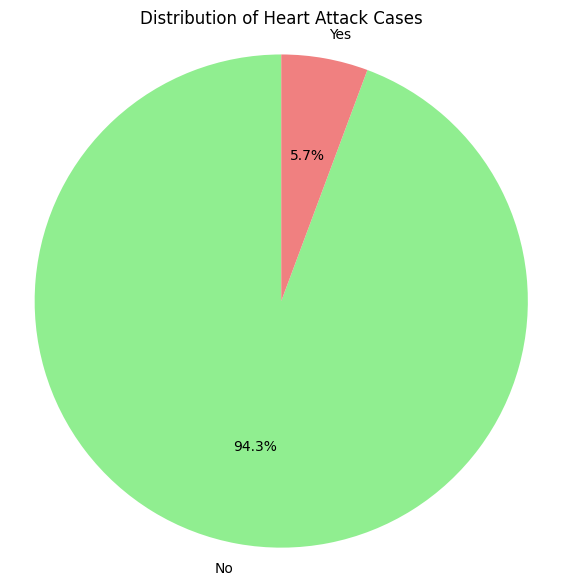

In [54]:
# Veriyi daha iyi anlamak için görselleştirme methodlarını kullanarak veriyi inceleyeceğiz
# kalp krizi geçirenlerin geçirmeyenlere oranını daire grafikte görelim

counts = df['HadHeartAttack'].value_counts()
labels = counts.index
values = counts.values


plt.figure(figsize=(7, 7))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
plt.title('Distribution of Heart Attack Cases')
plt.axis('equal')  # Daireyi düzgün yapmak için

plt.show()





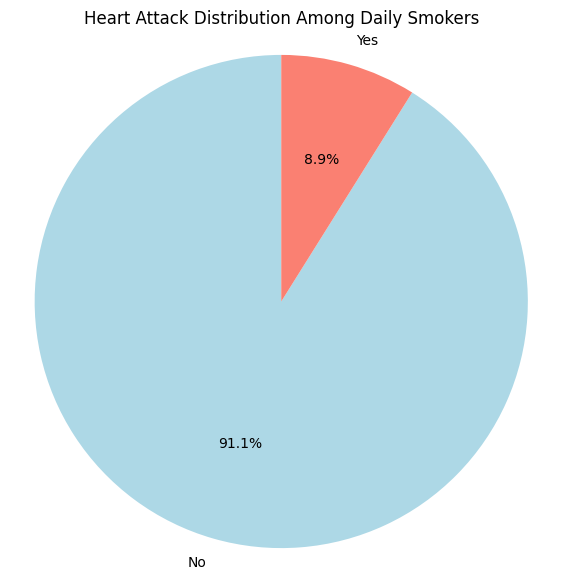

In [55]:
#şimdi düzenli sigara içenlerin arasındaki kalp krizi geçirme oranını inceleyelim

daily_smokers_df = df[df['SmokerStatus'] == 'Current smoker - now smokes every day']

heart_attack_counts_daily_smokers = daily_smokers_df['HadHeartAttack'].value_counts()
labels_daily_smokers = heart_attack_counts_daily_smokers.index
values_daily_smokers = heart_attack_counts_daily_smokers.values

plt.figure(figsize=(7, 7))
plt.pie(values_daily_smokers, labels=labels_daily_smokers, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
plt.title('Heart Attack Distribution Among Daily Smokers')
plt.axis('equal')  # Daireyi düzgün yapmak için

plt.show()


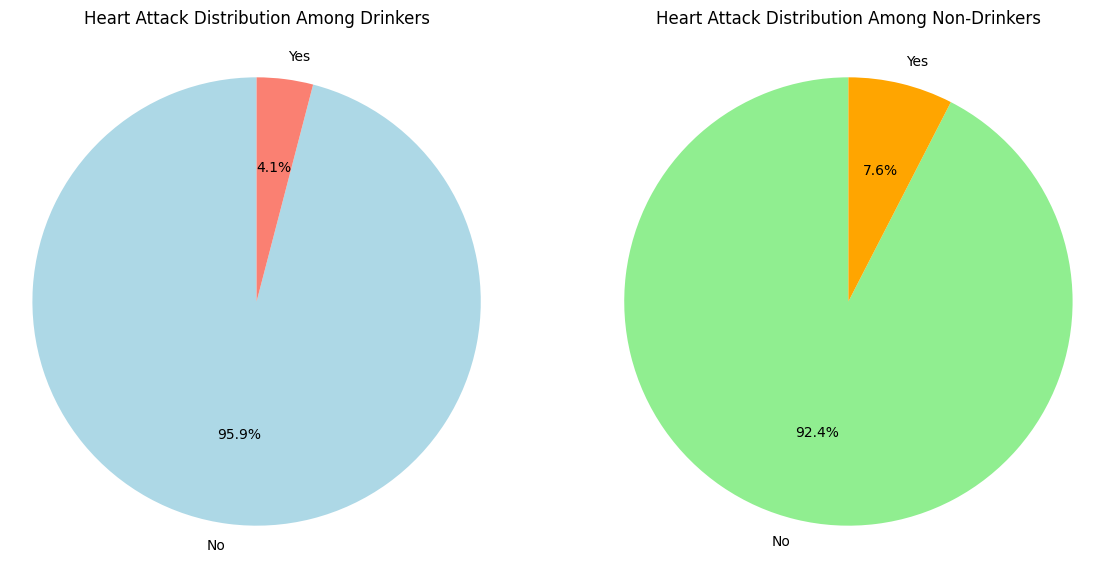

In [56]:
# alkol içenler ve içmeyenler arasındaki kalp krizi oranlarını karşılaştırmak için iki ayrı daire grafiği oluşturacağız

drinkers_df = df[df['AlcoholDrinkers'] == 'Yes']
non_drinkers_df = df[df['AlcoholDrinkers'] == 'No']

heart_attack_counts_drinkers = drinkers_df['HadHeartAttack'].value_counts()
labels_drinkers = heart_attack_counts_drinkers.index
values_drinkers = heart_attack_counts_drinkers.values

heart_attack_counts_non_drinkers = non_drinkers_df['HadHeartAttack'].value_counts()
labels_non_drinkers = heart_attack_counts_non_drinkers.index
values_non_drinkers = heart_attack_counts_non_drinkers.values

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.pie(values_drinkers, labels=labels_drinkers, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
plt.title('Heart Attack Distribution Among Drinkers')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.pie(values_non_drinkers, labels=labels_non_drinkers, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'orange'])
plt.title('Heart Attack Distribution Among Non-Drinkers')
plt.axis('equal')

plt.show()


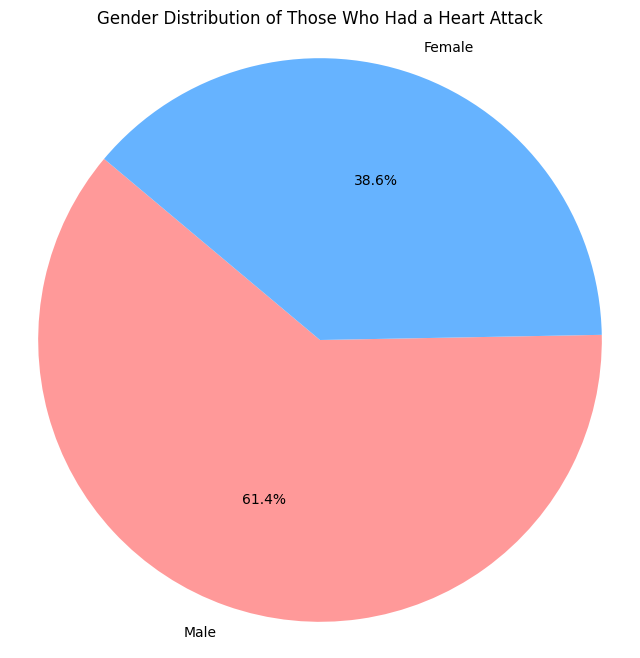

In [57]:
# Kalp krizi geçirenlerin cinsiyete göre dağılımı

heart_attack_df = df[df['HadHeartAttack'] == 'Yes']

gender_distribution = heart_attack_df['Sex'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(gender_distribution, labels=gender_distribution.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=140)
plt.title('Gender Distribution of Those Who Had a Heart Attack')
plt.axis('equal') 
plt.show()


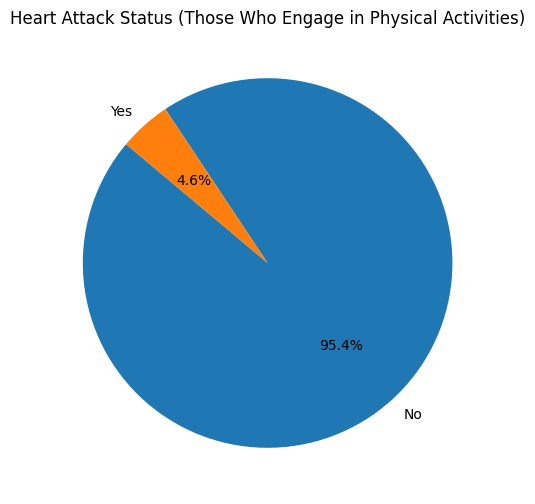

In [58]:
#Fiziksel Aktivite Yapanların Kalp Krizi Durumunu

df_active = df[df['PhysicalActivities'] == 'Yes']

heart_attack_counts = df_active['HadHeartAttack'].value_counts()
heart_attack_percentages = heart_attack_counts / heart_attack_counts.sum() * 100

plt.figure(figsize=(8, 6))
plt.pie(heart_attack_percentages, labels=heart_attack_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Heart Attack Status (Those Who Engage in Physical Activities)')
plt.show()



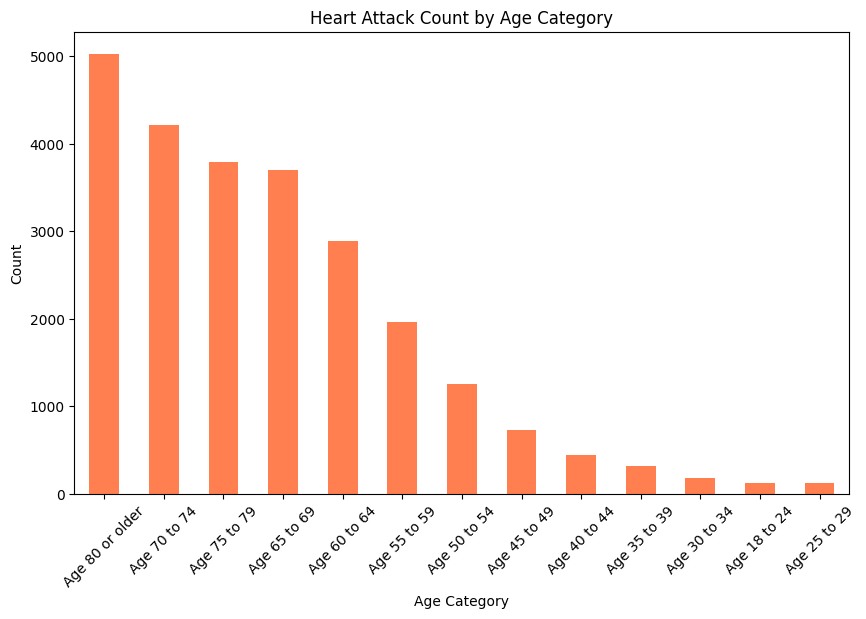

In [59]:
#şimdi kalp krizi geçirenlerin yaş dağılını inceleyelim

heart_attack = df[df['HadHeartAttack'] == 'Yes']

age_heart_attack_counts = heart_attack['AgeCategory'].value_counts()

plt.figure(figsize=(10, 6))
age_heart_attack_counts.plot(kind='bar', color='coral')
plt.title('Heart Attack Count by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


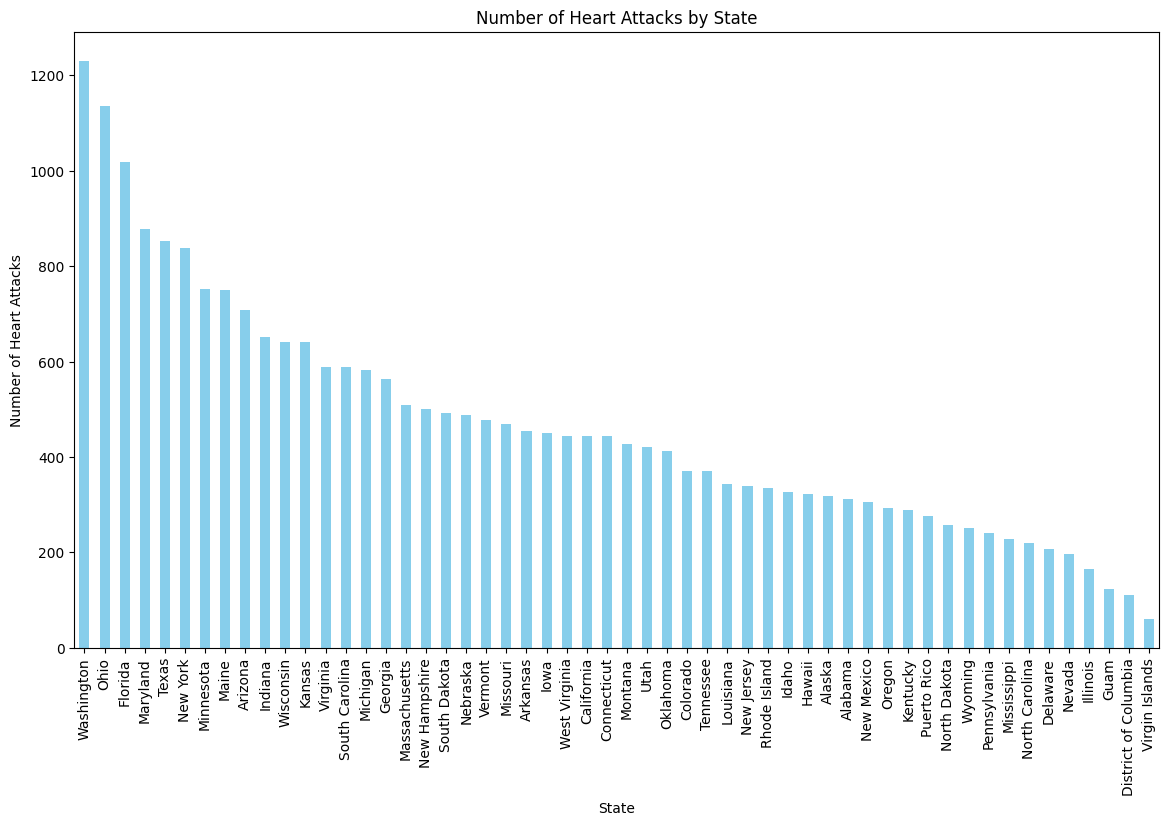

In [60]:
# kalp krizi geçirenlerin state lere göre dağılımı
state_heart_attack_counts = df[df['HadHeartAttack'] == "Yes"]['State'].value_counts()


plt.figure(figsize=(14, 8))
state_heart_attack_counts.plot(kind='bar', color='skyblue')
plt.xlabel('State')
plt.ylabel('Number of Heart Attacks')
plt.title('Number of Heart Attacks by State')
plt.xticks(rotation=90)
plt.show()


In [61]:
# Daha fazla veri görselleştirilebilir ancak çok fazla başlık olduğu için bukadar yeterli
# şimdi eksik verileri inceleyerek gerekli şeilde dolduracağız veya sileceğiz

missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percentage
})

missing_summary = missing_summary[missing_summary['Missing Values'] > 0].sort_values('Percentage (%)', ascending=False)

print(missing_summary)



                           Missing Values  Percentage (%)
TetanusLast10Tdap                   82516       18.537423
PneumoVaxEver                       77040       17.307226
HIVTesting                          66127       14.855593
ChestScan                           56046       12.590872
CovidPos                            50764       11.404258
HighRiskLastYear                    50623       11.372582
BMI                                 48806       10.964388
FluVaxLast12                        47121       10.585849
AlcoholDrinkers                     46574       10.462964
WeightInKilograms                   42078        9.452926
ECigaretteUsage                     35660        8.011107
SmokerStatus                        35462        7.966626
HeightInMeters                      28652        6.436742
DifficultyErrands                   25656        5.763684
DifficultyConcentrating             24240        5.445576
DifficultyWalking                   24012        5.394355
DifficultyDres

In [62]:
# eksik verileri dolduracağız silme yoluna gitmeyeceğiz çünkü eksik veri yüzdeleri içerisinde yüksek bir yüzde yok 
# sayısal verileri medyan yani ortalama değer ile dolduracağız
# kategorik değişkenleri ise mod yani en çok tekrar eden değer ile dolduracağız 


num_col = df.select_dtypes(include=["float64", "int64"]).columns
cat_col = df.select_dtypes(include=["object"]).columns


for col in num_col:
    median = df[col].median()
    df[col] = df[col].fillna(median)


for col in cat_col:
    mode = df[col].mode()[0]
    df[col] = df[col].fillna(mode)

In [63]:
# eksik veri kalıp kalmadığını kontrol edelim

missing = df.isnull().sum()

missing = missing[missing > 0]

print(missing)

Series([], dtype: int64)


In [64]:
# eksik  verilerin tamamını doldurduk ve şimdi bütün verileri eğitime hazır hale getirmek için
# sayısallaştırmalıyız

#önce zaten sayısal olan sütünları görelim

num_col = df.select_dtypes(include=["float64", "int64"]).columns

print(num_col)

Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI'],
      dtype='object')


In [65]:
# şimdi sadece 2 çeşit veri içeren sütunları("yes,"no" gibi) görelim

binary_columns = [col for col in df.columns if df[col].nunique() == 2]

for col in binary_columns:
    print(f"Column: {col}")
    print(f"Unique Values: {df[col].unique()}")
    print()


Column: Sex
Unique Values: ['Female' 'Male']

Column: PhysicalActivities
Unique Values: ['No' 'Yes']

Column: HadHeartAttack
Unique Values: ['No' 'Yes']

Column: HadAngina
Unique Values: ['No' 'Yes']

Column: HadStroke
Unique Values: ['No' 'Yes']

Column: HadAsthma
Unique Values: ['No' 'Yes']

Column: HadSkinCancer
Unique Values: ['No' 'Yes']

Column: HadCOPD
Unique Values: ['No' 'Yes']

Column: HadDepressiveDisorder
Unique Values: ['No' 'Yes']

Column: HadKidneyDisease
Unique Values: ['No' 'Yes']

Column: HadArthritis
Unique Values: ['No' 'Yes']

Column: DeafOrHardOfHearing
Unique Values: ['No' 'Yes']

Column: BlindOrVisionDifficulty
Unique Values: ['No' 'Yes']

Column: DifficultyConcentrating
Unique Values: ['No' 'Yes']

Column: DifficultyWalking
Unique Values: ['No' 'Yes']

Column: DifficultyDressingBathing
Unique Values: ['No' 'Yes']

Column: DifficultyErrands
Unique Values: ['No' 'Yes']

Column: ChestScan
Unique Values: ['No' 'Yes']

Column: AlcoholDrinkers
Unique Values: ['No' 'Y

In [66]:
#şimdi binary encodinng ile bu verileri sayısallaştıralım

binary_columns = [
    'PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke',
    'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
    'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing',
    'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking',
    'DifficultyDressingBathing', 'DifficultyErrands', 'ChestScan',
    'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
    'HighRiskLastYear'
]

for col in binary_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df['Sex'] = df['Sex'].map({'Female': 1, 'Male': 0})

In [67]:
# şimdi kalan kategorik değişkenleri ve tüm farklı verileri görelim

cat_cols = df.select_dtypes(include=["object"]).columns

for col in cat_cols:
    unique_values = df[col].unique()
    print(f"Column: {col}")
    print(f"Unique Values: {unique_values}\n")
    

Column: State
Unique Values: ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']

Column: GeneralHealth
Unique Values: ['Very good' 'Excellent' 'Fair' 'Poor' 'Good']

Column: LastCheckupTime
Unique Values: ['Within past year (anytime less than 12 months ago)'
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)'
 '5 or more years ago']

Column

In [68]:
#  State sütunu çok fazla çeşitli değer içeriyor ve ayrıca bu sütun yanıltıcı olabilir
#  çünkü şehirlerde görülen kalp krizi vakalarının çokluğu bölge nüfusuna göre
#  değişkenlik gösterebilir ve elimizde nüfusa ait bir bilgi yok eğer etiketlemek
#  istersek çok fazla sütun eklemiş olacağız bunun için bu sütunu sileceğiz
#  eğer model performansı çok düşük olursa yeniden göz gezdirebiliriz


df = df.drop(columns=['State'])

In [69]:
# şimdi GeneralHealth sütunu için ordinal encoding yapacağız çünkü sıralı yapıda

# GeneralHealth sütununu sayısallaştırma
health_mapping = {
    'Excellent': 5,
    'Very good': 4,
    'Good': 3,
    'Fair': 2,
    'Poor': 1
}

df['GeneralHealth'] = df['GeneralHealth'].map(health_mapping)

In [70]:
# LastCheckupTime için de ordinal encoding yapacağız

ordinal_mapping = {
    'Within past year (anytime less than 12 months ago)': 1,
    'Within past 2 years (1 year but less than 2 years ago)': 2,
    'Within past 5 years (2 years but less than 5 years ago)': 3,
    '5 or more years ago': 4
}

df['LastCheckupTime'] = df['LastCheckupTime'].map(ordinal_mapping)

In [71]:
# RemovedTeeth için de o.encoding

removed_teeth_mapping = {
    'None of them': 0,
    '1 to 5': 1,
    '6 or more, but not all': 2,
    'All': 3
}

df['RemovedTeeth'] = df['RemovedTeeth'].map(removed_teeth_mapping)

In [72]:
# HadDiabetes için one hot encoding çünkü genel bir sıralama yapsı yok

df = pd.get_dummies(df, columns=['HadDiabetes'])

In [73]:
# SmokerStatus için one hot encoding
df = pd.get_dummies(df, columns=['SmokerStatus'])

In [74]:
# ECigaretteUsage için one hot encoding
df = pd.get_dummies(df, columns=['ECigaretteUsage'])


In [75]:
# RaceEthnicityCategory için one hot encoding

df = pd.get_dummies(df, columns=['RaceEthnicityCategory'])

In [76]:
# yaş kategorisi için ordinal encoding uygun olacaktır

age_category_order = [
    'Age 18 to 24',
    'Age 25 to 29',
    'Age 30 to 34',
    'Age 35 to 39',
    'Age 40 to 44',
    'Age 45 to 49',
    'Age 50 to 54',
    'Age 55 to 59',
    'Age 60 to 64',
    'Age 65 to 69',
    'Age 70 to 74',
    'Age 75 to 79',
    'Age 80 or older'
]

age_category_mapping = {age: index for index, age in enumerate(age_category_order)}

df['AgeCategory'] = df['AgeCategory'].map(age_category_mapping)

In [77]:
# TetanusLast10Tdap için one hot encoding
df = pd.get_dummies(df, columns=['TetanusLast10Tdap'])

In [78]:
# CovidPos için binary encoding yapabiliriz 3.değer evet olarak değişebilir
df['CovidPos'] = df['CovidPos'].replace(
    'Tested positive using home test without a health professional', 
    'Yes'
)

# Apply binary encoding
df['CovidPos'] = df['CovidPos'].map({'No': 0, 'Yes': 1})


In [79]:
# son durumu inceleyelim 
for col in df.columns:
    print(f"{col}: {df[col].dtype}")


Sex: int64
GeneralHealth: int64
PhysicalHealthDays: float64
MentalHealthDays: float64
LastCheckupTime: int64
PhysicalActivities: int64
SleepHours: float64
RemovedTeeth: int64
HadHeartAttack: int64
HadAngina: int64
HadStroke: int64
HadAsthma: int64
HadSkinCancer: int64
HadCOPD: int64
HadDepressiveDisorder: int64
HadKidneyDisease: int64
HadArthritis: int64
DeafOrHardOfHearing: int64
BlindOrVisionDifficulty: int64
DifficultyConcentrating: int64
DifficultyWalking: int64
DifficultyDressingBathing: int64
DifficultyErrands: int64
ChestScan: int64
AgeCategory: int64
HeightInMeters: float64
WeightInKilograms: float64
BMI: float64
AlcoholDrinkers: int64
HIVTesting: int64
FluVaxLast12: int64
PneumoVaxEver: int64
HighRiskLastYear: int64
CovidPos: int64
HadDiabetes_No: bool
HadDiabetes_No, pre-diabetes or borderline diabetes: bool
HadDiabetes_Yes: bool
HadDiabetes_Yes, but only during pregnancy (female): bool
SmokerStatus_Current smoker - now smokes every day: bool
SmokerStatus_Current smoker - now

In [80]:
# şimdi normalleştirme yapacağız

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

numeric_columns = [
    'PhysicalHealthDays', 'MentalHealthDays', 'LastCheckupTime', 'SleepHours',
    'HeightInMeters', 'WeightInKilograms', 'BMI'
]

df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [81]:
# artık eğitime başlamaya hazırız bir kaç farklı model deneyerek sonuçları değerlendireceğiz
# dengesiz bir veri ile çalıştığımız için eğer iyi sonuçlar almazsak farklı yöntemler ile 
# veriyi dengelemeye çalışabiliriz


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X = df.drop(columns=['HadHeartAttack'])
y = df['HadHeartAttack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[82976   913]
 [ 3985  1153]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     83889
           1       0.56      0.22      0.32      5138

    accuracy                           0.94     89027
   macro avg       0.76      0.61      0.65     89027
weighted avg       0.93      0.94      0.93     89027



In [82]:
# eğitim sonucundan görülebileceği üzere modelin genel doğruluğu %94 olmasına rağmen
# kalp krizi olan durumların sadece %22 si kalp krizi olarak tahmin edilmiş

# yeni bir model denemeden önce bütün değerlere kalp krizi dediğimizde alacağımız doğruluğu
# ölçelim böylelikle modelin minimum durumdaki doğruluğunu görelim

from sklearn.metrics import accuracy_score

y_all = [0] * len(y_test)

accuracy_all = accuracy_score(y_test, y_all)

print(accuracy_all)

0.9422871713075809


In [83]:
# lojistik regrasyon modelini deneyelim

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

log_reg_model.fit(X_train, y_train)

y_pred_log_reg = log_reg_model.predict(X_test)

print(confusion_matrix(y_test, y_pred_log_reg))

print(classification_report(y_test, y_pred_log_reg))


[[82976   913]
 [ 3985  1153]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     83889
           1       0.56      0.22      0.32      5138

    accuracy                           0.94     89027
   macro avg       0.76      0.61      0.65     89027
weighted avg       0.93      0.94      0.93     89027



In [84]:
# yine istenen sonuca ulaşamadık
# şimdi Karar Ağaçları (Decision Trees) modeli ile eğitleim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop(columns=['HadHeartAttack'])
y = df['HadHeartAttack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[79501  4388]
 [ 3687  1451]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     83889
           1       0.25      0.28      0.26      5138

    accuracy                           0.91     89027
   macro avg       0.60      0.62      0.61     89027
weighted avg       0.91      0.91      0.91     89027



In [85]:
# Oversampling (Artırma) metodu ile azınlık olan veri türünün örneklerini çoğaltalım
# ve tekrar eğitelim

from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop(columns=['HadHeartAttack'])
y = df['HadHeartAttack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(random_state=42)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[81693  2196]
 [ 3301  1837]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     83889
           1       0.46      0.36      0.40      5138

    accuracy                           0.94     89027
   macro avg       0.71      0.67      0.68     89027
weighted avg       0.93      0.94      0.93     89027



In [86]:
# görüldüğü üzere Oversampling metodu ile eğitilen modelin doğruluğu önceki
# modellere göre her açıdan daha iyi sonuç verdi
# şimdi ise çoğunluk veriyi azaltma yöntemini yani Undersampling yöntemini deneyelim

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

X = df.drop(columns=['HadHeartAttack'])
y = df['HadHeartAttack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

undersampler = RandomUnderSampler(sampling_strategy=1/3, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

model = RandomForestClassifier(random_state=42)

model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[79083  4806]
 [ 2260  2878]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     83889
           1       0.37      0.56      0.45      5138

    accuracy                           0.92     89027
   macro avg       0.67      0.75      0.70     89027
weighted avg       0.94      0.92      0.93     89027



In [87]:
# Hiperparametre Optimizasyonu yapmayı dendim ancak 30 dakika geçmesine rağmen bitmedği için iptal ettim
# veriyi undersampling ettikten sonra Hiperparametre Optimizasyonu denedim ama yine bitmedi bu yüzden yapamadım



# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report, confusion_matrix
# from imblearn.under_sampling import RandomUnderSampler

# X = df.drop(columns=['HadHeartAttack'])
# y = df['HadHeartAttack']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# undersample = RandomUnderSampler(sampling_strategy=1/3, random_state=42)
# X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

# logistic_regression = LogisticRegression(solver='liblinear', random_state=42)

# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2'],
#     'max_iter': [100, 200, 300],
# }

# grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# grid_search.fit(X_train_resampled, y_train_resampled)

# print(grid_search.best_params_)
# print(grid_search.best_score_)

# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_test)

# print(confusion_matrix(y_test, y_pred_best))

# print(classification_report(y_test, y_pred_best))

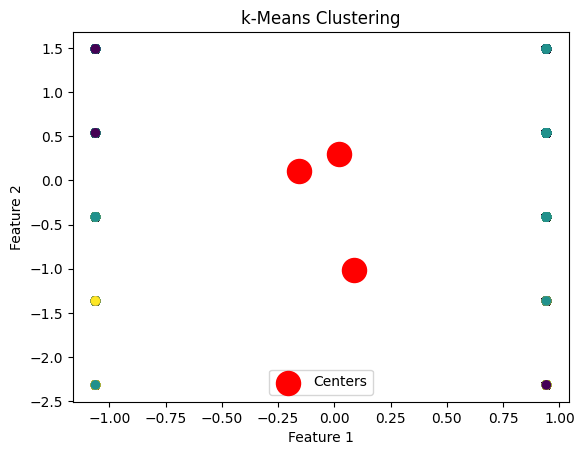

In [88]:
# şimdi ise gözetimsiz öğrenme yöntemleri ile eğitim yapalım

# k-Ortalama (k-Means) Kümeleme metodunu kullanalım

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

kmeans = KMeans(n_clusters=3, n_init=10, random_state=0) 
kmeans.fit(X_scaled)

df['Cluster'] = kmeans.labels_

centers = kmeans.cluster_centers_

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df['Cluster'], cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', label='Centers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('k-Means Clustering')
plt.legend()
plt.show()



In [89]:
# DBSCAN modelini denedim ama kodun çalışması sonlanmadı ve çıktı alamadım

# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)  

# dbscan = DBSCAN(eps=0.5, min_samples=5)  
# dbscan_labels = dbscan.fit_predict(X_scaled)

# plt.figure(figsize=(10, 6))
# plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=dbscan_labels, cmap='plasma')
# plt.title('DBSCAN Kümeleme Sonuçları')
# plt.xlabel('Özellik 1')
# plt.ylabel('Özellik 2')
# plt.colorbar(label='Küme Numaraları')
# plt.show()

# n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  
# n_noise = list(dbscan_labels).count(-1)

# print(n_clusters)
# print(n_noise)

In [90]:
# aynı lekilde hiperparemetre optimizasyonu da sonlanmadı

# from sklearn.model_selection import GridSearchCV
# from sklearn.cluster import DBSCAN
# from sklearn.metrics import make_scorer, silhouette_score
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# def silhouette_scorer(estimator, X):
#     labels = estimator.fit_predict(X)
#     if len(set(labels)) > 1:
#         return silhouette_score(X, labels)
#     else:
#         return -1  

# param_grid = {
#     'eps': [0.3, 0.5, 0.7],
#     'min_samples': [3, 5, 7]
# }

# dbscan = DBSCAN()
# grid_search = GridSearchCV(dbscan, param_grid, scoring=make_scorer(silhouette_scorer))
# grid_search.fit(X_scaled)

# print(f"En iyi parametreler: {grid_search.best_params_}")


In [91]:
# Sonuç 

# kullandığım data hadef değişkeni barındrdığı için "gözetimli öğrenme" methodlarının daha
# işlevsel ve kullanışlı olduğunu düşünüyorum

# hedef değişkenin olmadğı veriler için veri analizi ve kümeleme için kullanışlı olabilir

# gözetimli öğrenme kısmında yüksek bir doğrluk seviyesine ulaşamadım özellikle kalp krizi
# geçirenlerin tahmini kısmında başarı oranı düşük kaldı
# bunun sebebi verinin dengesiz olması ve eğitimin en iyi şekilde yapılamamış olması olabilir
